Code for analysing sailor dataset

In [2]:
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import get_max_intensity_for_dataset,  get_patients_from_txt, sort_imagedata_on_patients
from utils.model_utils import train_and_eval
from torch import nn
import os
# Dataleakage from Kmeans
os.environ["OMP_NUM_THREADS"] = "1"

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 512
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [3]:
from utils.datahandling_utils import createImageIndexCSV

image_data = createImageIndexCSV("D:/sailor_DCE/", force=False,
                                 result_file_path="./data_indexes/sailor_data_indices.csv")
mca_labels = pd.read_excel('./data_indexes/sailor_mca_labels.xlsx')

# Remove patients with artefacts and missing mca
for p in [3, 5, 7, 11, 12, 13, 14, 15, 17, 19, 20, 21, 23, 24, 25]:
    mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == p].index)
filtered_image_data = image_data[image_data['Patient'].isin(
    mca_labels['Patient'])]
filtered_image_data = filtered_image_data.drop(filtered_image_data[(
    filtered_image_data['Patient'] == 1) & (filtered_image_data['Series'] == 5)].index)
mca_labels = pd.melt(mca_labels, id_vars=[
                     'Patient', 'Series'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Series', 'Slice'])


In [4]:
intensities = get_max_intensity_for_dataset(
    filtered_image_data, path='./data_indexes/sailor_intensities.csv')


In [5]:
dist = get_patients_from_txt({"train": "./data_indexes/train_patients_sailor.txt",
                             "val": "./data_indexes/val_patients_sailor.txt", "test": "./data_indexes/test_patients_sailor.txt"})
train_images, val_images, test_images = sort_imagedata_on_patients(
    image_data, dist)

train_labels = np.isin(mca_labels['Patient'],
                       np.unique(train_images['Patient']))
train_labels = mca_labels[train_labels]
val_labels = np.isin(mca_labels['Patient'], np.unique(val_images['Patient']))
val_labels = mca_labels[val_labels]
test_labels = np.isin(mca_labels['Patient'], np.unique(test_images['Patient']))
test_labels = mca_labels[test_labels]


In [6]:
# Only keep the five first scans (series)
test_labels_filter = np.isin(test_labels['Series'], [1, 2, 3, 4, 5])
test_images_filter = np.isin(test_images['Series'], [1, 2, 3, 4, 5])
test_labels = test_labels[test_labels_filter]
test_images = test_images[test_images_filter]
test_images = test_images.drop(test_images[(
    test_images['Patient'] == 1) & (test_images['Series'] == 5)].index)


In [11]:
import json
with open('./trained_models/best_config.txt', 'r') as f:
    data = f.read()
    best_config = json.loads(data)


In [12]:
from models.dense_net_torch import DenseNet
torch.manual_seed(SEED)
model = DenseNet(growth_rate=best_config['growth_rate'], num_init_features=best_config['init_features'],
                 bn_size=best_config['bn_size'], drop_rate=best_config['drop_rate'], num_classes=1)
print(
    f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_config['lr'])
torch.cuda.empty_cache()
model.load_state_dict(torch.load('./trained_models/model_100_2023_5_4.pt'))
model = model.to(device)
model.eval()


Total number of trainable parameters 1541315


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 26, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(26, 60, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(60, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(41, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [13]:
import numpy as np
import sklearn
import os


class mouridsen2006():
    def __init__(self, seed, auc_frac=0.9, irr_frac=0.75, select_fun=None):
        self.seed = seed
        self.auc_frac = auc_frac
        self.irr_frac = irr_frac
        self.mask = None
        self.shapes = {'result_volume': None,
                       'filtered_volume': None, 'full_volume': None}
        self.masks = {'auc_mask': None, 'irr_mask': None}
        self.selected = []
        self.labels = []
        if select_fun is not None:
            self.select_fun = select_fun
        else:
            self.select_fun = self.select_curve

    def get_auc_frac(self, volume):
        auc = np.sum(volume, axis=0)
        return np.quantile(auc, self.auc_frac), auc

    def standardize_curves_on_area(self, volume, areas):
        volume = volume / areas
        return volume

    def get_irr_frac(self, volume):
        gradient = volume[1:] - volume[:-1]
        gradient2 = gradient[1:] - gradient[:-1]
        roughness = np.sum((gradient2*gradient2)**2, axis=0)
        return np.quantile(roughness, self.irr_frac), roughness

    def filter_volume(self, arr):
        auc_frac, auc = self.get_auc_frac(arr)
        self.masks['auc_mask'] = auc > auc_frac

        volume = self.standardize_curves_on_area(arr, auc)
        self.shapes['full_volume'] = volume.shape

        _, rough = self.get_irr_frac(volume)
        roughness_frac, _ = self.get_irr_frac(
            volume[:, self.masks['auc_mask']])
        self.masks['irr_mask'] = rough < roughness_frac

        filter_volume = volume[:, self.masks['auc_mask']
                               & self.masks['irr_mask']]
        self.shapes['filtered_volume'] = filter_volume.shape
        filter_volume = np.swapaxes(filter_volume, 0, 1)

        return filter_volume

    def select_curve(self, curves):
        # Selects curve with highest peak/AUC
        curve_peak = np.max(curves, axis=1)
        AUC = np.sum(curves, axis=1)
        idx = np.argmax(curve_peak / AUC)
        return idx

    def perform_kmeans(self, arr):
        os.environ["OMP_NUM_THREADS"] = '1'
        (_centroid, label, _inertia) = sklearn.cluster.k_means(
            arr, 5, n_init=10, random_state=self.seed)
        curves = np.zeros((5, arr.shape[1]))
        for i in range(5):
            curves[i] = np.average(arr[label == i], axis=0)
        select_idx = self.select_fun(curves)
        next_volume = arr[label == select_idx]
        self.selected.append(select_idx)
        self.labels.append(label)
        return next_volume

    def _compute_mask(self):
        mask = np.full((self.shapes['result_volume']), False)
        mask[:, self.labels[1] == self.selected[1]] = True
        mask1 = np.full(self.shapes['filtered_volume'], False)
        mask1[:, self.labels[0] == self.selected[0]] = mask
        mask2 = np.full(self.shapes['full_volume'], False)
        mask2[:, self.masks['auc_mask'] & self.masks['irr_mask']] = mask1
        self.mask = mask2

    def get_mask(self):
        return self.mask

    def predict(self, array, auc_norm=False):
        filtered_volume = self.filter_volume(array)
        first_kmeans = self.perform_kmeans(filtered_volume)
        self.shapes['result_volume'] = (
            first_kmeans.shape[1], first_kmeans.shape[0])
        last_kmeans = self.perform_kmeans(first_kmeans)
        self._compute_mask()
        if auc_norm:
            return last_kmeans
        curves = []
        for i in range(self.mask.shape[1]):
            slice_mask = self.mask[1, i, ...]
            curves.extend(np.swapaxes(array[:, i,  slice_mask], 0, 1))
        curves = np.array(curves)
        return curves


In [14]:
from operator import itemgetter
from models.mouridsen import get_AIF_KMeans
from utils.datahandling_utils import crop_image
# from models.mouridsen_new import mouridsen2006

pred_type = ["single", "sigmoid", "all", "global"]
"""
Pred type denotes which slices is to have the AIF extracted from.
single: The middle slice
sigmoid: The slice with the highest sigmoid value
all: All slices with a predicted MCA
global: All slices, global search
"""


def get_MCA_prediction(model, data: pd.DataFrame, intensities: np.array, device: str, crop: float, pred_type: str):
    model.eval()
    patient = np.unique(data['Patient'])[0]
    series_idx = np.unique(data['Series'])[0]
    volume = int(np.squeeze(intensities[np.where(
        (intensities[:, 0] == patient) & (intensities[:, 1] == series_idx))[0]])[2])
    slices = data.loc[(data['Patient'] == patient) &
                      (data['Volume'] == volume)].copy()
    slice_preds = []
    info = {}
    for i, (_, slice) in enumerate(slices.iterrows()):
        slice_num = slice['Slice']
        image = pdc.dcmread(slice['ImagePath'])
        if i == 3:
            info['FA'] = image.FlipAngle
            info['TR'] = image.RepetitionTime
            info['TD'] = image.EchoTime
        image = crop_image(image.pixel_array, crop)
        image = image/np.max(image)
        image = np.expand_dims(image, axis=(0, 1))
        image = torch.tensor(image, dtype=torch.float).to(device)
        pred = torch.sigmoid(model(image)).item()
        if pred >= 0.5:
            slice_preds.append((slice_num, pred))
    if pred_type == "single":
        slice_preds = sorted(slice_preds, key=itemgetter(0), reverse=True)
        idx = len(slice_preds) // 2
        return [slice_preds[idx][0]], info
    elif pred_type == "sigmoid":
        slice_preds = sorted(slice_preds, key=itemgetter(1), reverse=True)
        return [slice_preds[0][0]], info
    return [i[0] for i in slice_preds], info


def get_image_volume(image_data, patient, series, slice_idx):
    image_paths = image_data[(image_data['Patient'] == patient) &
                             (image_data['Series'] == series)]
    slice_filter = np.isin(image_paths['Slice'], slice_idx)
    image_paths = image_paths[slice_filter]
    return image_paths


def create_image_array(paths, crop=None):
    base_slice = pdc.read_file(paths.iloc[[0]]['ImagePath'].item())
    if crop is not None:
        base_slice = crop_image(base_slice.pixel_array, crop)
    else:
        base_slice = base_slice.pixel_array
    slice_idxs = np.unique(paths['Slice'])
    volume_idxs = np.unique(paths['Volume'])
    slices = np.zeros((len(volume_idxs), len(slice_idxs),
                      base_slice.shape[0], base_slice.shape[1]))

    for v_i, volume_num in enumerate(volume_idxs):
        for s_i, slice_num in enumerate(slice_idxs):
            path = paths[(paths['Volume'] == volume_num)
                         & (paths['Slice'] == slice_num)]
            image = pdc.read_file(path['ImagePath'].item())
            if crop is not None:
                image = crop_image(image.pixel_array, crop)
            else:
                image = image.pixel_array
            slices[v_i-1, s_i-1, :, :] = image
    return slices


def get_info(serie):
    info = {}
    img = serie.iloc[0]['ImagePath']
    image = pdc.read_file(img)
    info['FA'] = image.FlipAngle
    info['TR'] = image.RepetitionTime
    info['TD'] = image.EchoTime
    return info


def filter_slices_on_mca_prediction(data, patient_num: int, series, mca_slices: list, crop: int):
    image_paths = get_image_volume(data, patient_num, series, mca_slices)
    image = create_image_array(image_paths, crop)
    return image


def extract_AIF_mouridsen(images, SEED: int):
    kmeans = mouridsen2006(seed=SEED)
    curves = kmeans.predict(images)
    mask = kmeans.get_mask()
    return curves, mask


def new_single_eval_curve(model, image_data: pd.DataFrame, patients, vol_intensities: np.ndarray, device: str, seed: int, crop: float, pred_type: str):
    if pred_type not in ["single", "all", "global", "sigmoid"]:
        raise Exception(
            f"Arg: one_pred must be one of \"single\", \"all\", \"global\", \"sigmoid\". Given argument: \"{pred_type}\"")
    total_curves = {}
    all_masks = {}
    slice_info_dict = {}
    for patient in patients:
        patient_curves = {}
        patient_info = {}
        patient_mask = {}
        images = image_data[image_data['Patient'] == patient]
        for s in np.unique(images['Series']):
            serie = images[images['Series'] == s]

            if pred_type == 'global':
                MCA_slices = np.unique(images['Slice'])
                slice_info = get_info(serie)
                filtered_slices = filter_slices_on_mca_prediction(
                    serie, patient, s,  MCA_slices, crop)
            else:
                MCA_slices, slice_info = get_MCA_prediction(
                    model, serie, vol_intensities, device, 0.7, pred_type)
                filtered_slices = filter_slices_on_mca_prediction(
                    serie, patient, s, MCA_slices, crop)

            pred_curves, pred_mask = extract_AIF_mouridsen(
                filtered_slices, seed)

            total_mask = np.full(
                (pred_mask.shape[2], pred_mask.shape[3]), False)
            for i in range(pred_mask.shape[1]):
                total_mask = np.bitwise_or(total_mask, pred_mask[1, i, ...])

            patient_curves[s] = pred_curves
            patient_mask[s] = [total_mask, MCA_slices]
            patient_info[s] = slice_info

        total_curves[patient] = patient_curves
        all_masks[patient] = patient_mask
        slice_info_dict[patient] = patient_info

    return total_curves, slice_info_dict, all_masks


In [15]:
from utils.model_utils import get_pred_curves

p, i, m = new_single_eval_curve(model=model, image_data=test_images, patients=np.unique(test_images['Patient']), vol_intensities=intensities,
                                device=device, seed=SEED, crop=0.7, pred_type='sigmoid')


C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas


In [16]:
p_a, i_a, m_a = new_single_eval_curve(model=model, image_data=test_images, patients=np.unique(test_images['Patient']), vol_intensities=intensities,
                                      device=device, seed=SEED, crop=0.7, pred_type='all')


C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid valu

In [17]:
p_g, i_g, m_g = new_single_eval_curve(model=model, image_data=test_images, patients=np.unique(test_images['Patient']), vol_intensities=intensities,
                                      device=device, seed=SEED, crop=0.7, pred_type='global')


C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_18944\1244527450.py:27: RuntimeWarning: invalid valu

In [12]:
np.unique(test_images['Patient'])


array([ 1,  4,  6, 16, 27], dtype=int64)

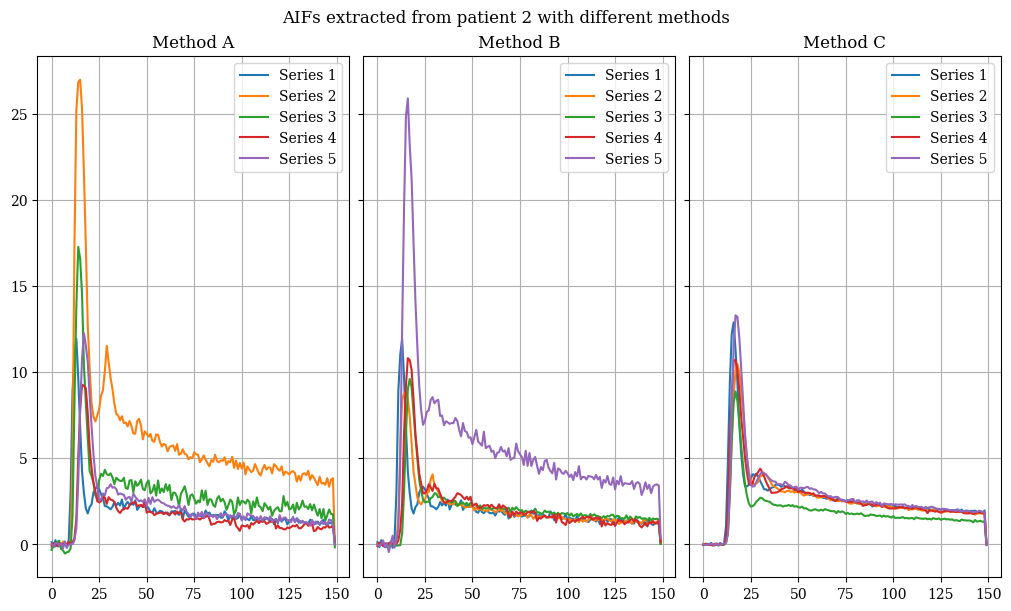

In [18]:
import matplotlib.pyplot as plt
from utils.signal_conversion import SR_s2r


def plot_curve_series(p, pas):
    fig = plt.figure(figsize=(6, 6))
    pas_p = p[pas]
    for series_key in list(pas_p.keys()):
        curve = np.average(pas_p[series_key], axis=0)
        plt.plot(SR_s2r(curve),
                 label=f"Series {series_key}")
    plt.title(f"AIFs for patient {pas}")
    plt.legend(loc='upper right')


def compare_plots(p, p_a, p_g, pas):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    fig, axs = plt.subplots(
        1, 3, sharey=True, figsize=(10, 6), layout='constrained')
    for ax, data, label in zip(axs, [p, p_a, p_g], ['Method A', 'Method B', 'Method C']):
        pas_p = data[pas]
        for series_key in list(pas_p.keys()):
            curve = np.average(pas_p[series_key], axis=0)
            ax.plot(SR_s2r(curve),
                    label=f"Series {series_key}")
        ax.set_title(f"{label}")
        ax.legend(loc='upper right')
        ax.grid()
    fig.suptitle('AIFs extracted from patient 2 with different methods')


compare_plots(p, p_a, p_g, 27)


In [22]:
from utils.datahandling_utils import crop_image
def get_image(image_data, intensities, patient, series, slice_idx, crop=0.7):
    volume = intensities[(intensities[:,0] == patient) & (intensities[:,1] == series)][0][2]
    image_path = image_data[(image_data['Patient'] == patient) & ((image_data['Series'] == series) & ((image_data['Volume'] == volume) & (image_data['Slice'] == slice_idx)))]['ImagePath']
    image = pdc.read_file(image_path.item()).pixel_array
    image = crop_image(image, crop)
    return image

def print_curves_and_coords(p, m, patient, image_data, intensities):
    """
    Accepts p where there are only a single selected slice.
    """
    p = p[patient]
    rows = len(p.keys())
    fig, ax = plt.subplots(rows, 2, figsize=(9, 10), sharex = 'col')
    fig.suptitle(f"AIFs and their corresponding locations for patient 5")
    for i, series_key in enumerate(list(p.keys())):
        curves = p[series_key]
        curve = np.average(p[series_key], axis=0)
        
        for c in curves:
            ax[i, 0].plot(SR_s2r(c), alpha=0.2)
        ax[i,0].plot(SR_s2r(curve), color='red')

        mask = m[patient][series_key][0]
        slices = m[patient][series_key][1]
        if len(slices) > 1:
            slice_idx = np.random.choice(slices)
        else:
            slice_idx = slices[0]
        image = get_image(filtered_image_data, intensities, patient, series_key, slice_idx)
        ax[i,1].imshow(image, cmap="gray")
        ax[i,1].imshow(mask, alpha=0.4, cmap=plt.cm.OrRd)
        ax[i,0].set_title(f"AIF curves in series {series_key} and slice {sorted(slices)[0]}")
        ax[i,0].grid()
        ax[i,1].set_title("Voxels in the AIF")
        ax[i,1].axis('off')
    # plt.tight_layout()
    plt.show()
    

In [79]:
m[1][1][1][0]


6

In [23]:
def compare_coords(m, m_a, m_g, pas, test_images, intensities):
    rows = len(m[pas])
    fig, axs = plt.subplots(rows, 3, sharex='col',
                            figsize=(6, 10), layout='tight')
    for row, series_key in enumerate(m[pas].keys()):
        slice_idx = m[pas][series_key][1][0]
        for col, data in enumerate([m, m_a, m_g]):
            mask = data[pas][series_key][0]
            image = get_image(test_images, intensities,
                              pas, series_key, slice_idx, 1)
            axs[row, col].imshow(image, cmap='gray')
            axs[row, col].imshow(mask, alpha=0.4, cmap=plt.cm.OrRd)
            axs[row, col].axis('off')
            if row == 0:
                if col == 0:
                    axs[row, col].set_title('Method A')
                elif col == 1:
                    axs[row, col].set_title('Method B')
                else:
                    axs[row, col].set_title('Method C')
    fig.supylabel('Series')
    fig.suptitle('Extraction masks from different methods for patient 2')


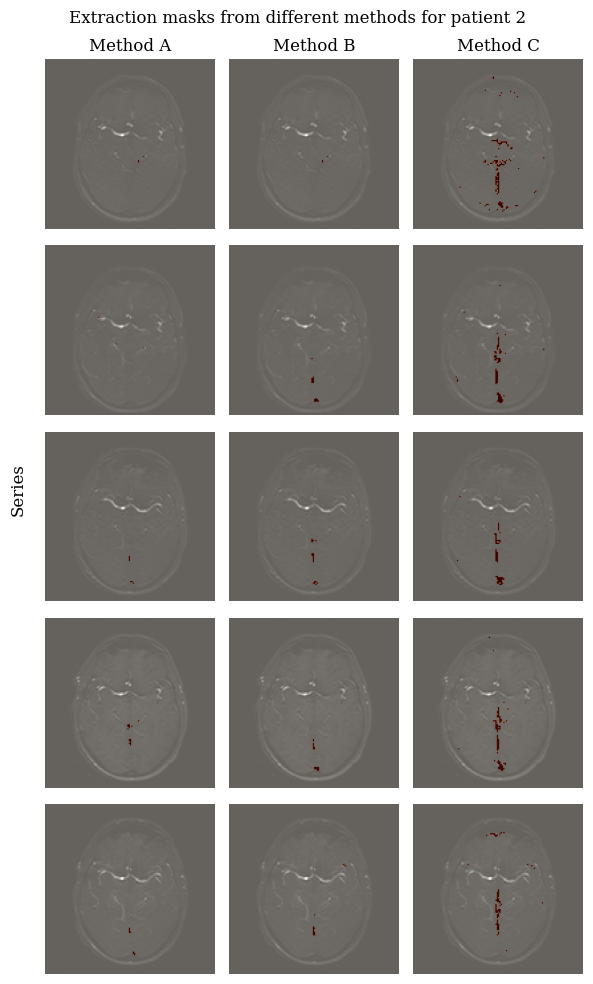

In [182]:
compare_coords(m, m_a, m_g, 27, test_images, intensities)


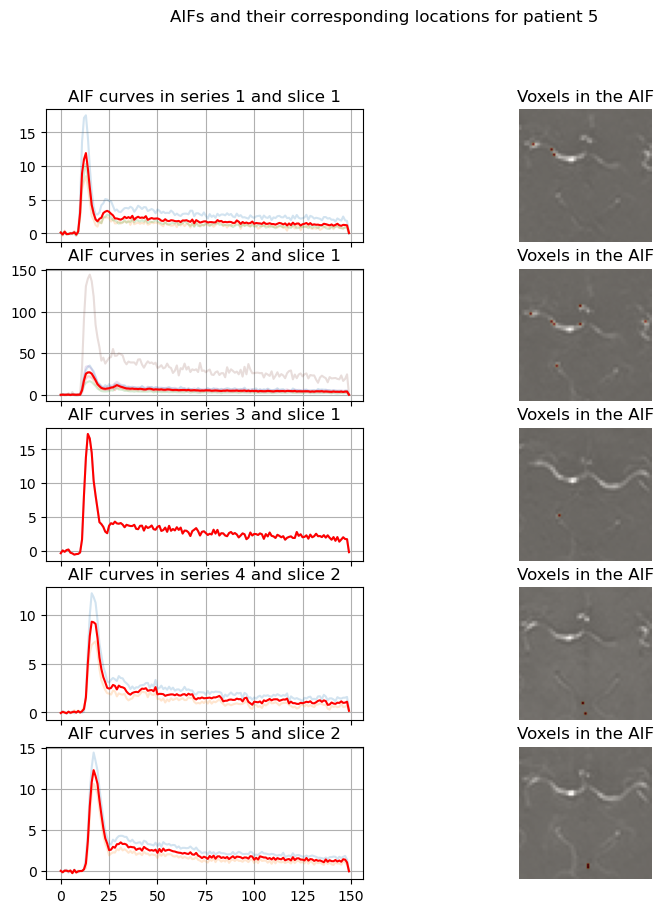

In [42]:
print_curves_and_coords(p, m, 27, test_images, intensities)


In [ ]:
# Delta AUC, delta TTP, delta PTB, delta S, Pearson S


In [24]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


def get_curves(p):
    curves = []
    for series_key in list(p.keys()):
        curve = np.average(p[series_key], axis=0)
        curve = SR_s2r(curve)
        curves.append(curve)
    return np.array(curves)


def get_curves_metrics(curves):
    AUC = []
    TTP = []
    PTB = []
    for curve in curves:
        AUC.append(np.sum(curve))
        TTP.append(np.argmax(curve))
        PTB.append(np.max(curve) - np.average([curve[:4]]))
    return np.array(AUC), np.array(TTP), np.array(PTB)


def get_diff(vals):
    first = vals[:-1]
    next = vals[1:]
    return next-first


def get_pearson(values):
    pears = []
    if len(values.shape) > 1:
        for i in range(values.shape[0]-1):
            first = values[i]
            next = values[i+1]
            pears.append(pearsonr(first, next))
    else:
        first = values[:-1]
        next = values[1:]
        pears.append(pearsonr(first, next))
    return np.array(pears)


In [25]:
def get_curve_metrics_dataframe(p, file_path):
    cols = ['Patient', 'meAUC', 'seAUC', 'meTTP', 'seTTP',
            'mePTB', 'sePTB', 'rCurve', 'c_Curve']
    results = []
    for patient in list(p.keys()):
        c = get_curves(p[patient])
        a, t, b = get_curves_metrics(c)
        da = get_diff(a)
        sa, ma = np.std(da), np.mean(da)
        dt = get_diff(t)
        st, mt = np.std(dt), np.mean(dt)
        db = get_diff(b)
        sb, mb = np.std(db), np.mean(db)
        ps = get_pearson(c)
        results.append([patient, ma, np.max(np.abs(da)), mt, np.max(np.abs(dt)),
                       mb, np.max(np.abs(db)), np.average(ps[:, 0]), np.average(ps[:, 1])])
    df = pd.DataFrame(results, columns=cols)
    df.to_csv(file_path)
    return df


In [58]:
def get_curve_metrics_array(p, diff=True):
    results = [[], [], [], []]
    for patient in list(p.keys()):
        c = get_curves(p[patient])
        a, t, b = get_curves_metrics(c)
        da = get_diff(a)
        dt = get_diff(t)
        db = get_diff(b)
        ps = get_pearson(c)
        dp = get_diff(ps[:, 0])
        if diff:
            results[0].extend(da)
            results[1].extend(dt)
            results[2].extend(db)
            results[3].extend(ps[:, 0])
        else:
            results[0].append(a)
            results[1].append(t)
            results[2].append(b)
            results[3].append(ps[:, 0])
    return results


In [36]:
res_p = get_curve_metrics_array(p)
res_pa = get_curve_metrics_array(p_a)
res_pg = get_curve_metrics_array(p_g)


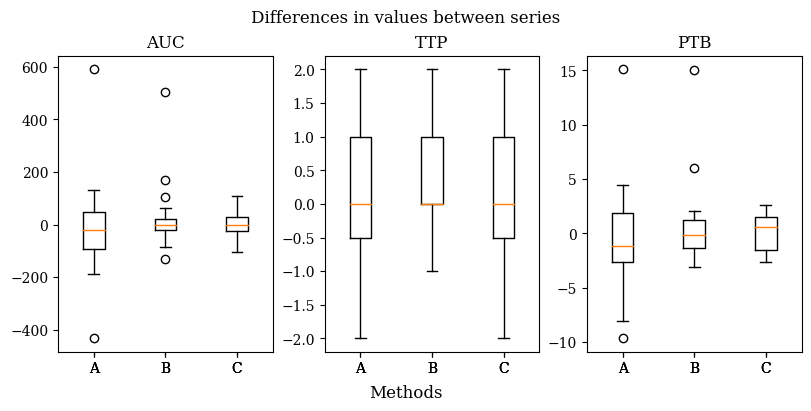

In [62]:
fig, axs = plt.subplots(1, 3, layout='constrained',
                        figsize=(8, 4), sharex=True)
axs[0].boxplot([res_p[0], res_pa[0], res_pg[0]], labels=['A', 'B', 'C'])
axs[0].set_title('AUC')

axs[1].boxplot([res_p[1], res_pa[1], res_pg[1]], labels=['A', 'B', 'C'])
axs[1].set_title('TTP')

axs[2].boxplot([res_p[2], res_pa[2], res_pg[2]], labels=['A', 'B', 'C'])
axs[2].set_title('PTB')

fig.supxlabel('Methods')
fig.suptitle('Differences in values between series')
plt.show()


In [56]:
nodiff_p = get_curve_metrics_array(p, False)
nodiff_pa = get_curve_metrics_array(p_a, False)
nodiff_pg = get_curve_metrics_array(p_g, False)


In [52]:
print(np.mean(nodiff_p[1]), np.mean(nodiff_pa[1]), np.mean(nodiff_pg[1]))
print(np.std(nodiff_p[1]), np.std(nodiff_pa[1]), np.std(nodiff_pg[1]))


11.75 11.708333333333334 12.75
2.367312118556965 2.57357026111371 2.9755951785595207


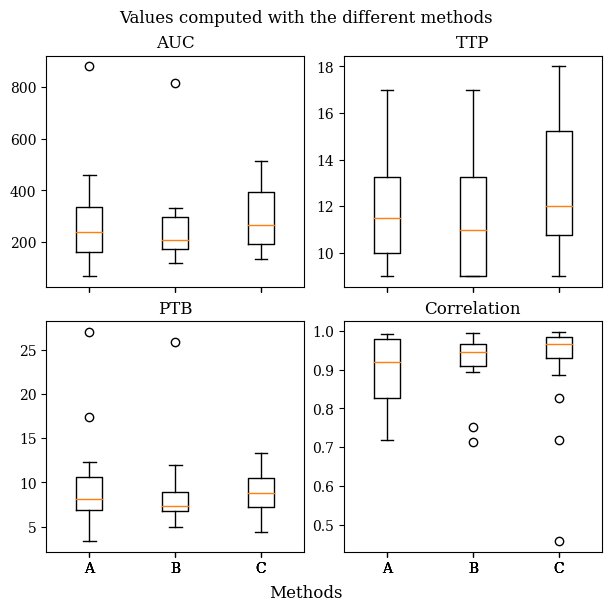

In [42]:
fig, axs = plt.subplots(2, 2, layout='constrained',
                        figsize=(6, 6), sharex=True)
axs[0, 0].boxplot([nodiff_p[0], nodiff_pa[0], nodiff_pg[0]],
                  labels=['A', 'B', 'C'])
axs[0, 0].set_title('AUC')

axs[0, 1].boxplot([nodiff_p[1], nodiff_pa[1], nodiff_pg[1]],
                  labels=['A', 'B', 'C'])
axs[0, 1].set_title('TTP')

axs[1, 0].boxplot([nodiff_p[2], nodiff_pa[2], nodiff_pg[2]],
                  labels=['A', 'B', 'C'])
axs[1, 0].set_title('PTB')

fig.supxlabel('Methods')
fig.suptitle('Values computed with the different methods')
plt.show()


In [214]:
def get_curve_TTPs(p):
    results = []
    for patient in list(p.keys()):
        c = get_curves(p[patient])
        a, t, b = get_curves_metrics(c)
        results.extend(t)
    return np.array(results)


In [198]:
list(p.keys())


[1, 4, 6, 16, 27]

In [226]:
np.mean(get_curve_TTPs(p))


11.75

In [151]:
df = get_curve_metrics_dataframe(p, './metric_data/sigmoid_sailor.csv')
df_a = get_curve_metrics_dataframe(p_a, './metric_data/all_mca_sailor.csv')
df_g = get_curve_metrics_dataframe(p_g, './metric_data/global_sailor.csv')


In [169]:
np.mean(df_g['sePTB'])


2.5974162110913275

In [14]:
# for patient in [ 1,  4,  6, 16, 27]:
#     p, i = single_eval_curve(model, filtered_image_data, patient, intensities,
#                             device, SEED, 0.7, False, 'sigmoid', 5)


In [41]:
arr_paths = get_image_volume(test_images, 1, 4, [6])
arr = create_image_array(arr_paths, 0.7)


In [284]:
from models.mouridsen_new import mouridsen2006
kmeans = mouridsen2006()
curves = kmeans.predict(arr)
mask = kmeans.get_mask()


C:\Users\svenalrik\AppData\Local\Temp\ipykernel_28964\1591083245.py:18: RuntimeWarning: invalid value encountered in divide
  volume = volume / areas


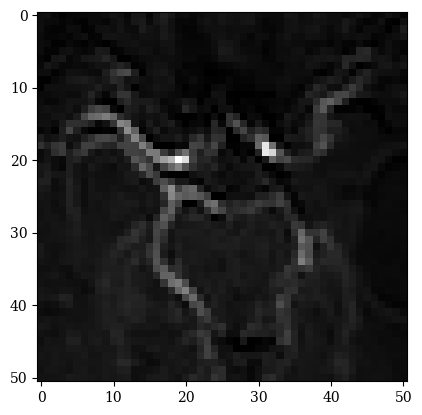

In [32]:
# plt.imshow(mask[1, 0, ...])
plt.imshow(arr[9, 1, ...], cmap='gray')


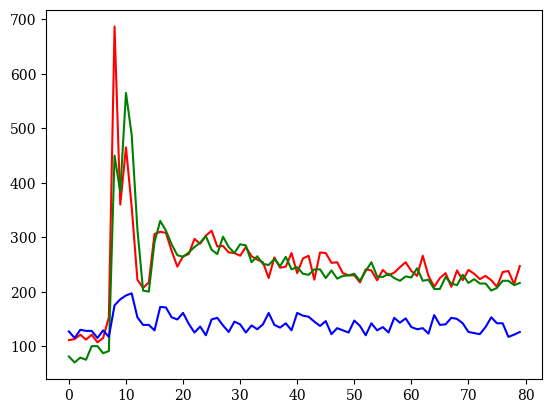

In [40]:
fig = plt.figure()
plt.plot(arr[:80, 1, 20, 35], color='red')
plt.plot(arr[:80, 1, 35, 35], color='green')
plt.plot(arr[:80, 1, 25, 10], color='blue')


In [87]:
from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

mourd = mouridsen2006(SEED)
mourd.predict(arr[:, 1, ...])


(51, 51)

In [90]:
test_mask = np.bitwise_and(mourd.masks['auc_mask'], mourd.masks['irr_mask'])


In [91]:
graph = image.img_to_graph(arr[10, 1, ...], mask=test_mask)


In [1]:
test_images.iloc[0]


NameError: name 'test_images' is not defined